<a href="https://colab.research.google.com/github/LauraJDiaz/Ciencia-De-Datos/blob/main/Apikey_LOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas requests

In [ ]:
import requests
import pandas as pd
from time import sleep

API_KEY = "RGAPI-772f3514-72af-4d29-b928-519a0c83e6f1"
RIOT_ID = "Veroluna32"
TAG_LINE = "LAN"
HEADERS = {"X-Riot-Token": API_KEY}

In [ ]:
!GET https://<region>.api.riotgames.com/lol/match/v5/matches/<matchId>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `GET https://<region>.api.riotgames.com/lol/match/v5/matches/<matchId>'


In [ ]:
# Obtener el Puuid del jugador
def get_puuid(game_name, tag_line):
    url = f"https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name}/{tag_line}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()["puuid"]
    except Exception as e:
        print(f"Error al obtener PUUID: {str(e)}")
        return None

# Obtener Historial de las partidas
def get_match_history(puuid, count=10, start=0):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start={start}&count={count}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f" Error al obtener historial: {str(e)}")
        return None

In [ ]:
# Datos de la partida
def get_match_details(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f" Error en match {match_id}: {str(e)}")
        return None


# --- 4. Obtener datos extendidos ---
def get_extended_data(match_id, puuid):
    match_data = get_match_details(match_id)
    if not match_data:
        return None

    try:
        participant = next(p for p in match_data["info"]["participants"] if p["puuid"] == puuid)

        return {
            # Datos base
            "puuid": puuid,
            "summoner_id": participant["summonerId"],
            "summoner_name": participant["summonerName"],
            "date": match_data["info"]["gameCreation"],
            "region": match_data["info"]["gameMode"],
            "game_id": match_data["metadata"]["matchId"],
            "match_id": match_id,
            "champion": participant["championName"],
            "win": participant["win"],
            "kills": participant["kills"],
            "deaths": participant["deaths"],
            "assists": participant["assists"],
            "kda": round((participant["kills"] + participant["assists"]) / max(1, participant["deaths"]), 2),
            "cs": participant["totalMinionsKilled"] + participant["neutralMinionsKilled"],
            "vision_score": participant["visionScore"],
            "gold_earned": participant["goldEarned"],
            "gold_spent": participant["goldSpent"],
            "total_damage_dealt": participant["totalDamageDealtToChampions"],
            "total_damage_taken": participant["totalDamageTaken"],
            "magic_damage_dealt": participant["magicDamageDealtToChampions"],
            "physical_damage_dealt": participant["physicalDamageDealtToChampions"],
            "true_damage_dealt": participant["trueDamageDealtToChampions"],
            "timeCCingOthers": participant["timeCCingOthers"],
            "total_minions_killed": participant["totalMinionsKilled"],
            "largest_killing_spree": participant["largestKillingSpree"],
            "largest_multi_kill": participant["largestMultiKill"],
            "killing_sprees": participant["killingSprees"],
            "perks": participant["perks"],
            "longest_time_spent_living": participant["longestTimeSpentLiving"],
            "total_units_healed": participant["totalUnitsHealed"],
            "totalTimeSpentDead": participant["totalTimeSpentDead"],
            "vision_wards_bought_in_game": participant["visionWardsBoughtInGame"],
            "game_duration": match_data["info"]["gameDuration"] // 60,
            "queue_id": match_data["info"]["queueId"],
            "team_position": participant["teamPosition"],
            "lane": participant["lane"],
            "role": participant["role"],
            "level": participant["champLevel"],
            "game_version": match_data["info"]["gameVersion"],
            "map_id": match_data["info"]["mapId"],
            "game_name": match_data["info"]["gameName"],
            "game_creation": match_data["info"]["gameCreation"],
            "game_version": match_data["info"]["gameVersion"],
            "game_type": match_data["info"]["gameType"],
            "platform_id": match_data["info"]["platformId"],
            "participants": match_data["info"]["participants"],
            "teams": match_data["info"]["teams"],
            "items": [participant[f"item{i}"] for i in range(7)],
            "summoner_spells": [participant["summoner1Id"], participant["summoner2Id"]],
            "damage_to_champs": participant["totalDamageDealtToChampions"],
            "damage_taken": participant["totalDamageTaken"],
            "dragons_killed": participant["dragonKills"],
            "barons_killed": participant["baronKills"],
            "turret_kills": participant["turretKills"],
            "wards_placed": participant["wardsPlaced"],
            "wards_destroyed": participant["wardsKilled"]
        }
    except Exception as e:
        print(f"Error procesando {match_id}: {str(e)}")
        return None

In [ ]:
# --- EJECUCIÓN PRINCIPAL ---
print("Iniciando extracción...")
puuid = get_puuid(RIOT_ID, TAG_LINE)

if puuid:
    print(f"PUUID obtenido: {puuid}")
    match_ids = get_match_history(puuid, count=100)  # Puedes aumentar el count

    if match_ids:
        all_matches = []
        for match_id in match_ids:
            match_data = get_extended_data(match_id, puuid)
            if match_data:
                all_matches.append(match_data)
            sleep(1.5)  # Respeta el rate limit

        df = pd.DataFrame(all_matches)

        # Guardar en Excel
        filename = f"lol_data_{RIOT_ID}.xlsx"
        df.to_excel(filename, index=False)
        print(f"Datos guardados en '{filename}'")

        # Descargar automáticamente en Colab
        try:
            from google.colab import files
            files.download(filename)
            print("Archivo descargado!")
        except:
            print("Ejecutando localmente - revisa el archivo en tu directorio")
    else:
        print(" No se encontraron partidas")
else:
    print("No se pudo obtener PUUID - Verifica:")
    print(f"- API Key (¿generada en las últimas 24 horas?)")
    print(f"- Riot ID: '{RIOT_ID}#{TAG_LINE}' (¿existe?)")

Iniciando extracción...
PUUID obtenido: CEHgYdCxn7fQTZUFFQOvV9RP1Zq41i9mCDwhQ7RaETA64oP6CAgMGQtuz1sL0hWLjtkFErNuOf5gXw
Datos guardados en 'lol_data_UwU OwO Arf Arf.xlsx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo descargado!


In [ ]:
import requests
import pandas as pd

# --- CONFIGURACIÓN ---
API_KEY = "RGAPI-a969a155-c069-4b8e-8984-42fdb1576b0f"  # Reemplaza si expiró
HEADERS = {"X-Riot-Token": API_KEY}

def get_match_details(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error en detalles del match: {str(e)}")
        return None

def get_match_timeline(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error en timeline del match: {str(e)}")
        return None

def get_player_positions(match_id, puuid):
    match_data = get_match_details(match_id)
    timeline = get_match_timeline(match_id)

    if not match_data or not timeline:
        return None

    # Encontrar participantId
    try:
        participant = next(p for p in match_data["info"]["participants"] if p["puuid"] == puuid)
        participant_id = participant["participantId"]
    except:
        print("No se encontró el participantId para ese puuid.")
        return None

    posiciones = []

    for frame in timeline["info"]["frames"]:
        timestamp = frame["timestamp"]
        try:
            pos = frame["participantFrames"][str(participant_id)]["position"]
            posiciones.append({
                "timestamp_ms": timestamp,
                "x": pos["x"],
                "y": pos["y"]
            })
        except KeyError:
            continue

    return pd.DataFrame(posiciones)

# --- EJECUCIÓN ---
match_id = "LA1_1621953043"  # Reemplaza con el match real
puuid = "k1k5fHA2INWB_2FMjlEJJhL8tHvCnKVAvIF8NLSLDU6u8Tk1KxdN0Apdo2sKZTrSUMCuZlOl8O6aBw"  # Tu puuid

df_pos = get_player_positions(match_id, puuid)

if df_pos is not None:
    df_pos.to_excel("coordenadas_lol.xlsx", index=False)
    print("Coordenadas guardadas correctamente.")
else:
    print("No se pudo generar el DataFrame.")


Coordenadas guardadas correctamente.


In [ ]:
df_pos

,timestamp_ms,x,y
0,0,14539,14394
1,60005,8760,7968
2,120013,12371,6489
3,180027,6690,9388
4,240054,13663,13960
5,300164,2986,12735
6,360193,11327,8316
7,420206,3338,10758
8,480219,10304,5309
9,540231,11160,8344


DataFrame de eventos de ejemplo creado:
   timestamp_ms      x      y
0             0  14539  14394
1         60005   8760   7968
2        120013  12371   6489
3        180027   6690   9388
4        240054  13663  13960

ERROR: No se encontró la imagen del mapa.
Por favor, descarga una imagen del mapa de la Grieta del Invocador y
colócala en la misma carpeta que tu script, o especifica la ruta completa.
Por ejemplo, busca 'Summoner's Rift map clean' en Google Images.


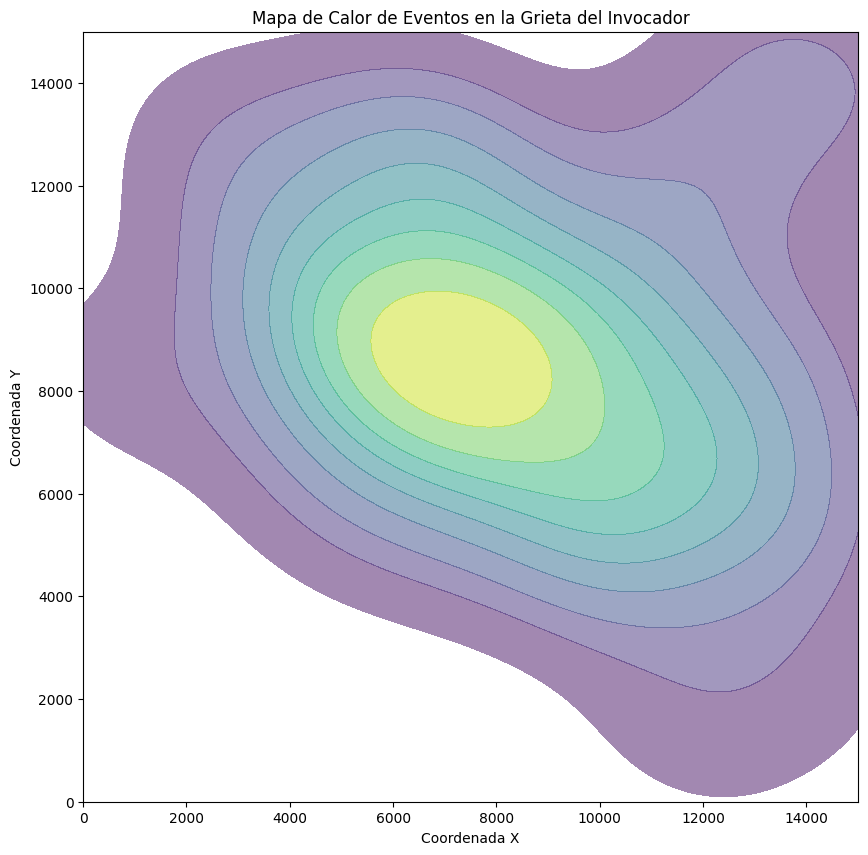

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.offsetbox import AnnotationBbox, OffsetImage # Para posibles futuros usos de imágenes

# Asegurarse de que las coordenadas estén dentro de los límites del mapa (ej. 0 a 15000)
x_coords = np.array(df_pos['x'])
y_coords = np.clip(np.array(df_pos['y']), 0, 15000)  # Limita las coordenadas en el rango [0, 15000]

df_eventos_lol = pd.DataFrame({
    'timestamp_ms': df_pos['timestamp_ms'],
    'x': df_pos['x'],
    'y': df_pos['y']
})

print("DataFrame de eventos de ejemplo creado:")
print(df_eventos_lol.head())


# --- 2. Cargar la imagen del mapa de LoL ---
# RUTA A TU IMAGEN DEL MAPA DE LOL
# ¡IMPORTANTE!: Reemplaza 'path/to/your/lol_map.png' con la ruta real de tu imagen.
# Descarga una imagen del mapa de la Grieta del Invocador (Summoner's Rift)
# Por ejemplo: 'summoners_rift_map.png' o 'lol_map_clean.jpg'
try:
    mapa_lol_img = plt.imread('summoners_rift_map.png') # <--- ¡CAMBIA ESTA RUTA!
except FileNotFoundError:
    print("\nERROR: No se encontró la imagen del mapa.")
    print("Por favor, descarga una imagen del mapa de la Grieta del Invocador y")
    print("colócala en la misma carpeta que tu script, o especifica la ruta completa.")
    print("Por ejemplo, busca 'Summoner's Rift map clean' en Google Images.")
    # Si no tienes la imagen, puedes salir o usar un plot vacío para ver el KDE sin fondo.
    exit() # Sale del script si no encuentra la imagen

# --- 3. Configuración del gráfico ---
fig, ax = plt.subplots(figsize=(10, 10)) # Un tamaño cuadrado suele ser mejor para mapas

# Dibuja la imagen del mapa como fondo
# extent=[x_min, x_max, y_min, y_max] define las coordenadas que corresponden a los bordes de la imagen
# Las coordenadas de LoL van de 0 a aproximadamente 14870 o 15000.
# Ajusta 'extent' si tu mapa de LoL tiene diferentes límites o si tus coordenadas no son de 0 a 15000.
map_x_min, map_x_max = 0, 15000
map_y_min, map_y_max = 0, 15000

# Dibuja el KDE
# Usa df_eventos_lol['x'] y df_eventos_lol['y'] para tus datos
sns.kdeplot(
    x=df_eventos_lol['x'],
    y=df_eventos_lol['y'],
    ax=ax,
    levels=10,        # Menos niveles para una visualización más suave o más niveles para detalle
    fill=True,        # Rellena el área entre los contornos (equivalente a 'shade=True')
    cmap='viridis',   # Mapa de colores (puedes probar 'hot', 'Reds', 'Blues', etc.)
    alpha=0.5,        # Transparencia del mapa de calor para que el mapa de fondo sea visible
    zorder=1,         # Dibuja el KDE encima del mapa (zorder del mapa es 0)
    thresh=0.05       # Umbral para no dibujar contornos muy bajos (opcional)
)

# Configuración de los ejes y título
ax.set_xlim(map_x_min, map_x_max)
ax.set_ylim(map_y_min, map_y_max)
ax.set_title('Mapa de Calor de Eventos en la Grieta del Invocador')
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')

# Opcional: Para ocultar las etiquetas de los ejes si solo quieres ver el mapa de calor
# ax.set_xticks([])
# ax.set_yticks([])

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive montado correctamente.
DataFrame de posiciones 'df_pos' listo:
   timestamp_ms      x      y
0             0  14539  14394
1         60005   8760   7968
2        120013  12371   6499
3        180027   6690   9388
4        240054  13663  13360
✅ Imagen del mapa cargada correctamente desde Drive: /content/drive/MyDrive/Imagenmapalol.png
Dimensiones de la imagen de fondo: (701, 705, 3)


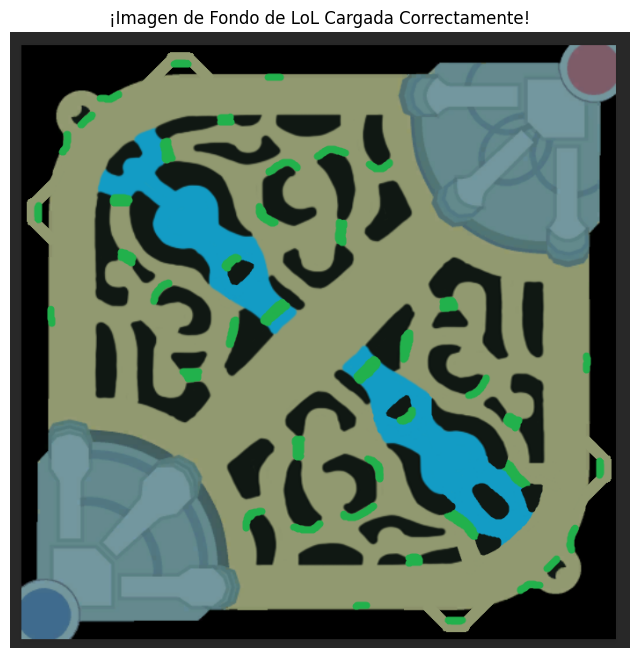

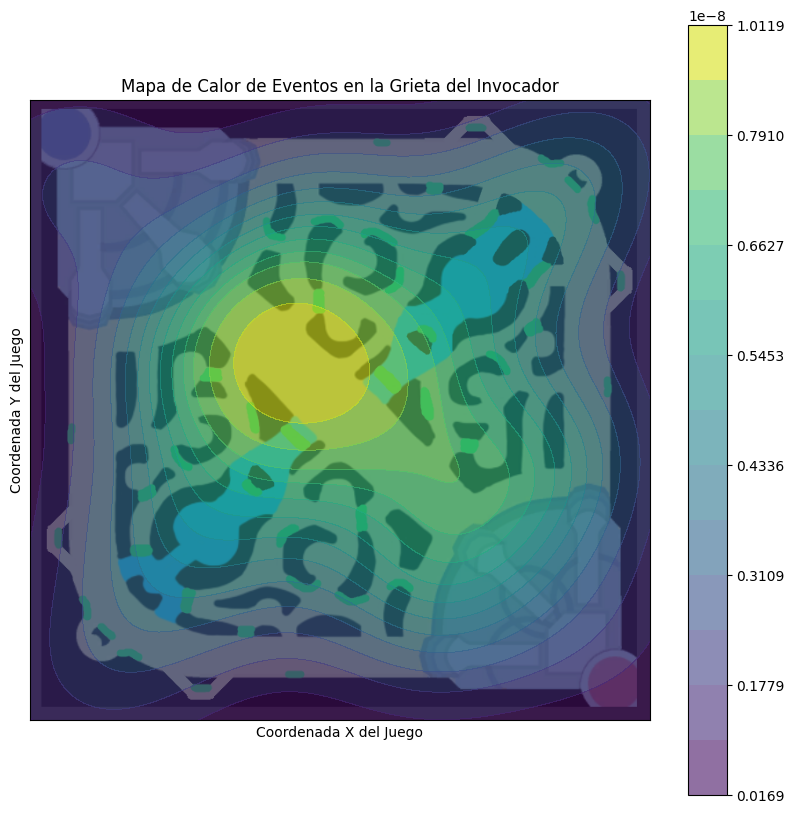

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image # Necesario para cargar imágenes desde Drive a veces
from google.colab import drive # Importa la librería para montar Drive

# --- 1. Montar Google Drive ---
# Ejecuta esta celda. Te pedirá que autorices Google Colab para acceder a tu Drive.
# Sigue las instrucciones y pega el código de autorización.
try:
    drive.mount('/content/drive')
    print("✅ Google Drive montado correctamente.")
except Exception as e:
    print(f"❌ ERROR al montar Google Drive: {e}")
    print("Asegúrate de tener una cuenta de Google y de autorizar el acceso.")
    # Si el Drive no se monta, el script no podrá encontrar la imagen.
    # Considera subir la imagen directamente a la sesión de Colab si tienes problemas con Drive.

# --- 2. Cargar tu DataFrame df_pos (si aún no está cargado) ---
# Si tu df_pos ya está definido en tu entorno de Colab, puedes comentar o eliminar este bloque.
data = {
    'timestamp_ms': [0, 60005, 120013, 180027, 240054, 300194, 360193, 420206, 480219, 540231, 600246, 660272, 720282, 780290, 840293, 900301, 960328, 1020352, 1080394, 1140383, 1200393, 1260410, 1320436, 1380463, 1440486, 1500000, 1560000, 1620000, 1680000, 1740000, 1800000, 1860000, 1920000, 1980000, 2040000, 2100000, 2160000, 2220000, 2280000, 2340000, 2400000, 2460000, 2520000, 2580000, 2640000, 2700000, 2760000, 2820000, 2880000, 2940000],
    'x': [14539, 8760, 12371, 6690, 13663, 11327, 3338, 10304, 11160, 5313, 4729, 819, 6779, 13592, 9650, 8158, 4910, 6609, 6697, 7022, 10436, 10581, 5519, 13338, 1000, 14000, 7500, 2000, 11000, 8000, 9000, 5000, 12000, 3000, 10000, 6000, 4000, 13000, 2500, 9500, 1500, 12500, 7000, 3500, 10500, 4500, 11500, 6500, 8500, 5500],
    'y': [14394, 7968, 6499, 9388, 13360, 12735, 8316, 10758, 5309, 8344, 9588, 12868, 8231, 7307, 2681, 4486, 7311, 9514, 12888, 11392, 5340, 6178, 9093, 5155, 13000, 2000, 7000, 1000, 3000, 12000, 4000, 11000, 6000, 9000, 2500, 10000, 3500, 11500, 5000, 8000, 1500, 12500, 7500, 4500, 9500, 5500, 10500, 6500, 8500, 3000]
}
df_pos = pd.DataFrame(data)

print("DataFrame de posiciones 'df_pos' listo:")
print(df_pos.head())

# Puedes aplicar clipping si lo necesitas, aunque con los datos de ejemplo no es estrictamente necesario
# x_coords_clipped = np.clip(df_pos['x'].values, 0, 15000)
# y_coords_clipped = np.clip(df_pos['y'].values, 0, 15000)


# --- 3. Cargar la imagen del mapa de LoL desde Google Drive ---
# ¡MUY IMPORTANTE!: Reemplaza 'ruta/a/tu_carpeta/nombre_de_tu_imagen.png'
# con la ruta real de tu imagen en Google Drive.
# Ejemplo: '/content/drive/MyDrive/MisMapas/Summoners_Rift_Minimap.png'
map_image_path_drive = '/content/drive/MyDrive/Imagenmapalol.png' # <--- ¡AJUSTA ESTA RUTA!

try:
    mapa_lol_img = Image.open(map_image_path_drive)
    print(f"✅ Imagen del mapa cargada correctamente desde Drive: {map_image_path_drive}")
    mapa_lol_img_array = np.array(mapa_lol_img)
    print(f"Dimensiones de la imagen de fondo: {mapa_lol_img_array.shape}")

    # Opcional: Mostrar la imagen de fondo sola para verificar
    plt.figure(figsize=(8,8))
    plt.imshow(mapa_lol_img_array)
    plt.title("¡Imagen de Fondo de LoL Cargada Correctamente!")
    plt.axis('off') # Ocultar ejes
    plt.show()

except FileNotFoundError:
    print(f"❌ ERROR: No se encontró la imagen en la ruta de Drive: {map_image_path_drive}")
    print("Asegúrate de que la ruta sea correcta y que la imagen exista en tu Google Drive.")
    # Crea un fondo negro de respaldo si la imagen no se encuentra
    mapa_lol_img_array = np.zeros((1500, 1500, 3), dtype=np.uint8) # Tamaño aproximado del mapa de LoL
    print("Se usará un fondo negro como respaldo.")
except Exception as e:
    print(f"❌ ERROR al cargar la imagen desde Drive: {e}")
    mapa_lol_img_array = np.zeros((1500, 1500, 3), dtype=np.uint8) # Fondo negro de respaldo
    print("Se usará un fondo negro como respaldo.")


# --- 4. Configuración del gráfico ---
fig, ax = plt.subplots(figsize=(10, 10)) # Un tamaño cuadrado es ideal para el mapa de LoL

# Define los límites del mapa de LoL en coordenadas del juego.
# La Grieta del Invocador suele ir de 0 a ~15000 en ambos ejes.
map_x_min, map_x_max = 0, 15000
map_y_min, map_y_max = 0, 15000

# Dibuja la imagen del mapa como fondo
# 'extent' mapea las coordenadas (x,y) del plot a los límites de la imagen.
# 'origin='lower'' si la esquina (0,0) del mapa de LoL es la parte inferior izquierda.
# 'zorder=0' asegura que el mapa esté en la capa más baja.
ax.imshow(mapa_lol_img_array, extent=[map_x_min, map_x_max, map_y_min, map_y_max],
          origin='lower', # O 'upper' si tu imagen tiene el origen en la parte superior izquierda
          zorder=0)

# --- 5. Dibuja el mapa de calor de densidad (KDE) ---
sns.kdeplot(
    x=df_pos['x'],
    y=df_pos['y'],
    ax=ax,
    levels=15,         # Número de contornos/niveles para el mapa de calor. Ajusta para más o menos detalle.
    fill=True,         # Rellena el área entre los contornos.
    cmap='viridis',    # Mapa de colores. 'viridis', 'plasma', 'inferno', 'magma', 'hot', 'Reds', 'Blues'.
    alpha=0.6,         # Transparencia del mapa de calor (0 = invisible, 1 = opaco).
    zorder=1,          # Dibuja el KDE encima del mapa.
    thresh=0.01,       # Umbral mínimo de densidad para dibujar contornos.
    cbar=True          # Muestra la barra de color.
)

# --- 6. Configuración final de los ejes y título ---
ax.set_xlim(map_x_min, map_x_max)
ax.set_ylim(map_y_min, map_y_max) # Asegúrate de que los límites del eje Y sean consistentes con el mapa

ax.set_title('Mapa de Calor de Eventos en la Grieta del Invocador')
ax.set_xlabel('Coordenada X del Juego')
ax.set_ylabel('Coordenada Y del Juego')

# Opcional: Ocultar los ticks y etiquetas de los ejes si solo quieres ver el mapa de calor limpio
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


✅ Imagen del mapa cargada correctamente desde: /content/drive/MyDrive/Imagenmapalol.png
Dimensiones de la imagen de fondo: (701, 705, 3)


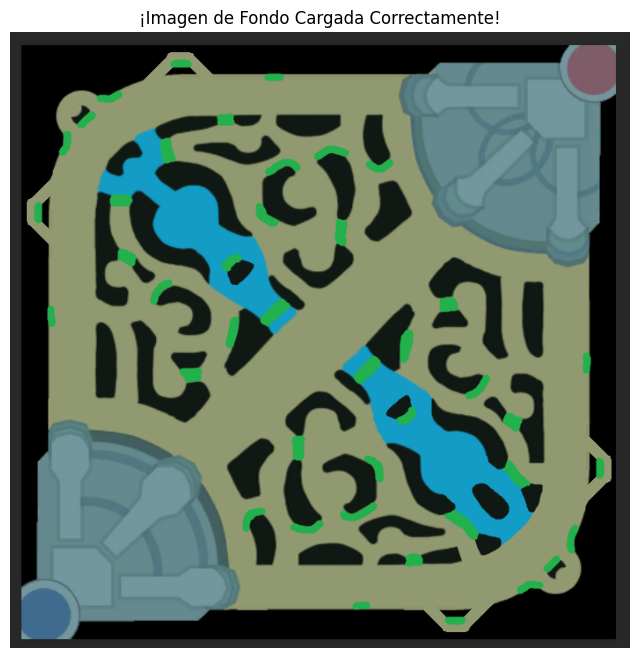

Número de puntos de datos: 50
Rango original X: [819, 14539]
Rango original Y: [1000, 14394]
Dimensiones de la imagen para escalado: Ancho=705, Alto=701
Rango escalado X: [0.0, 705.0]
Rango escalado Y: [0.0, 701.0]
Forma del heatmap generado: (150, 150)
Valor máximo en el heatmap: 1.0


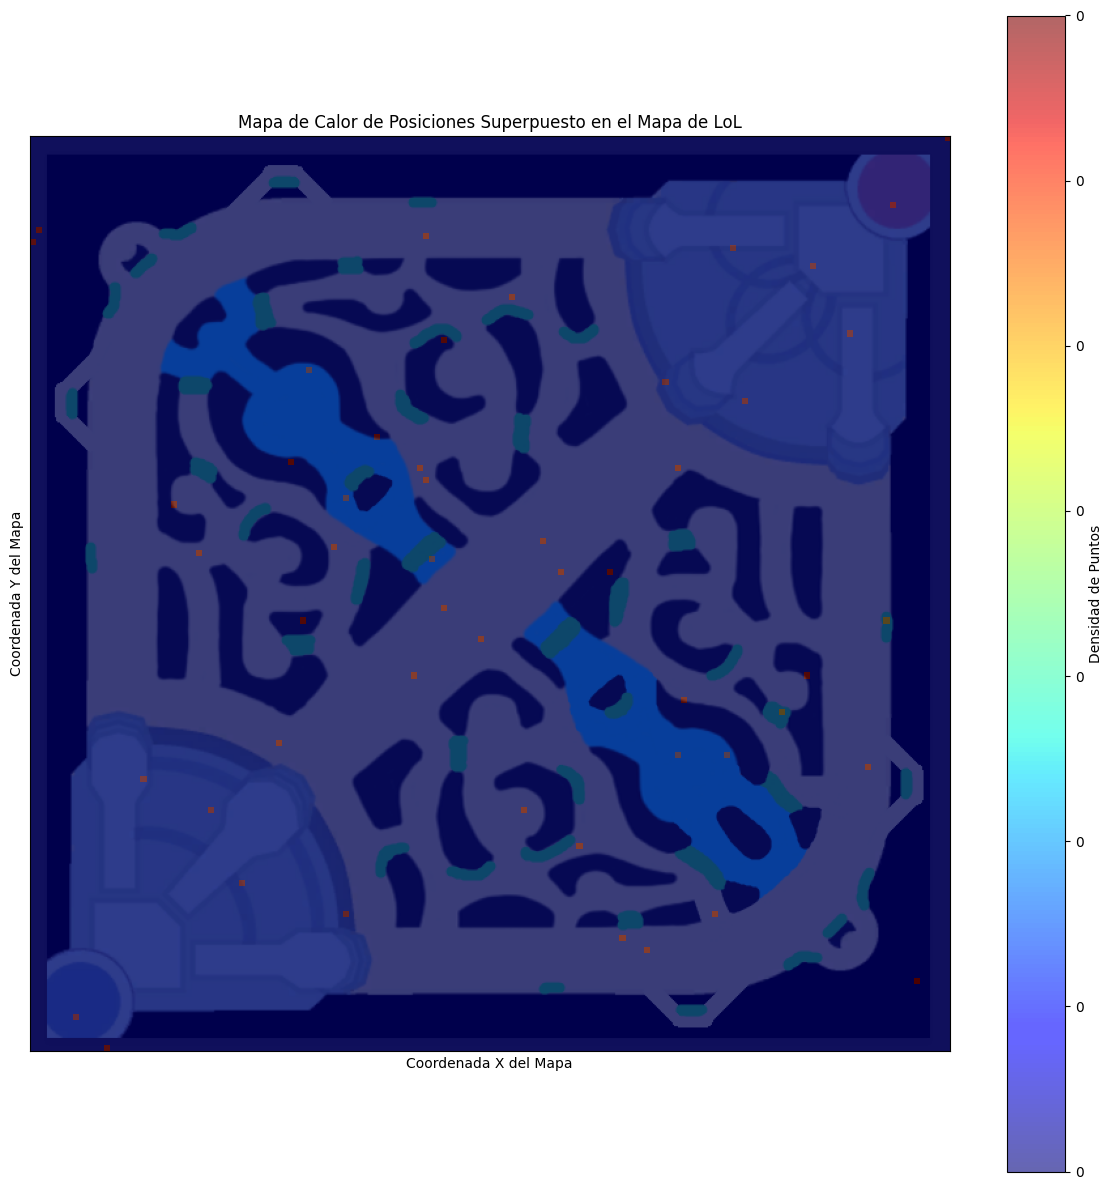

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

# --- Cargar la imagen de fondo (ELIGE SOLO UNA OPCIÓN Y AJUSTA LA RUTA) ---

# OPCIÓN A: Si la subiste directamente a la sesión de Colab (ej. Summoners_Rift_Minimap.png)
map_image_path = '/content/drive/MyDrive/Imagenmapalol.png' # Reemplaza con el nombre exacto de tu archivo
# OPCIÓN B: Si la tienes en Google Drive (después de montar Drive)
# map_image_path = '/content/drive/MyDrive/tu_carpeta/Summoners_Rift_Minimap.png' # ¡Cambia esta ruta!

try:
    map_img = Image.open(map_image_path)
    print(f"✅ Imagen del mapa cargada correctamente desde: {map_image_path}")
    map_img_array = np.array(map_img)
    print(f"Dimensiones de la imagen de fondo: {map_img_array.shape}")
    # Mostrar la imagen de fondo sola para verificar
    plt.figure(figsize=(8,8))
    plt.imshow(map_img_array)
    plt.title("¡Imagen de Fondo Cargada Correctamente!")
    plt.axis('off') # Ocultar ejes
    plt.show()

except FileNotFoundError:
    print(f"❌ ERROR: No se encontró la imagen en la ruta: {map_image_path}")
    print("Asegúrate de que la ruta sea correcta y que la imagen esté en Colab o Drive.")
    map_img_array = np.zeros((600, 600, 3), dtype=np.uint8) # Fondo negro de respaldo
    print("Se usará un fondo negro por defecto.")
except Exception as e:
    print(f"❌ ERROR al cargar la imagen: {e}")
    map_img_array = np.zeros((600, 600, 3), dtype=np.uint8) # Fondo negro de respaldo
    print("Se usará un fondo negro por defecto.")


# Resto del código (asumiendo que map_img_array ahora tiene la imagen o es negro)
# --- 2. Simulación o carga de los datos de coordenadas (x, y) ---
# Usaremos los datos que ya tenemos de las imágenes que proporcionaste.
# Si tu df_pos ya está cargado en Colab, omite este bloque.
data = {
    'timestamp_ms': [0, 60005, 120013, 180027, 240054, 300194, 360193, 420206, 480219, 540231, 600246, 660272, 720282, 780290, 840293, 900301, 960328, 1020352, 1080394, 1140383, 1200393, 1260410, 1320436, 1380463, 1440486, 1500000, 1560000, 1620000, 1680000, 1740000, 1800000, 1860000, 1920000, 1980000, 2040000, 2100000, 2160000, 2220000, 2280000, 2340000, 2400000, 2460000, 2520000, 2580000, 2640000, 2700000, 2760000, 2820000, 2880000, 2940000],
    'x': [14539, 8760, 12371, 6690, 13663, 11327, 3338, 10304, 11160, 5313, 4729, 819, 6779, 13592, 9650, 8158, 4910, 6609, 6697, 7022, 10436, 10581, 5519, 13338, 1000, 14000, 7500, 2000, 11000, 8000, 9000, 5000, 12000, 3000, 10000, 6000, 4000, 13000, 2500, 9500, 1500, 12500, 7000, 3500, 10500, 4500, 11500, 6500, 8500, 5500],
    'y': [14394, 7968, 6499, 9388, 13360, 12735, 8316, 10758, 5309, 8344, 9588, 12868, 8231, 7307, 2681, 4486, 7311, 9514, 12888, 11392, 5340, 6178, 9093, 5155, 13000, 2000, 7000, 1000, 3000, 12000, 4000, 11000, 6000, 9000, 2500, 10000, 3500, 11500, 5000, 8000, 1500, 12500, 7500, 4500, 9500, 5500, 10500, 6500, 8500, 3000]
}
df_pos = pd.DataFrame(data)

x_coords = df_pos['x'].values
y_coords = df_pos['y'].values

print(f"Número de puntos de datos: {len(x_coords)}")
print(f"Rango original X: [{np.min(x_coords)}, {np.max(x_coords)}]")
print(f"Rango original Y: [{np.min(y_coords)}, {np.max(y_coords)}]")

# --- 3. Normalizar/Escalar las coordenadas al tamaño de la imagen de fondo ---
img_height, img_width = map_img_array.shape[:2]

min_x_data, max_x_data = np.min(x_coords), np.max(x_coords)
min_y_data, max_y_data = np.min(y_coords), np.max(y_coords)

# Escalar X: Mapear el rango de tus datos X (min_x_data a max_x_data)
# al rango de píxeles de la imagen (0 a img_width).
scaled_x = ((x_coords - min_x_data) / (max_x_data - min_x_data)) * img_width

# Escalar Y: Mapear el rango de tus datos Y (min_y_data a max_y_data)
# al rango de píxeles de la imagen (0 a img_height).
scaled_y = ((y_coords - min_y_data) / (max_y_data - min_y_data)) * img_height

# --- IMPORTANTE para la orientación del mapa de LoL ---
# Los mapas de juego (y las imágenes) a menudo tienen el origen (0,0) en la esquina SUPERIOR izquierda.
# Las coordenadas cartesianas estándar (como las tuyas) tienen el origen (0,0) en la esquina INFERIOR izquierda.
# Si tu mapa de calor se ve invertido verticalmente, debes invertir el eje Y escalado.
# ¡Descomenta la siguiente línea si el mapa de calor está al revés verticalmente!
# scaled_y = img_height - scaled_y

print(f"Dimensiones de la imagen para escalado: Ancho={img_width}, Alto={img_height}")
print(f"Rango escalado X: [{np.min(scaled_x)}, {np.max(scaled_x)}]")
print(f"Rango escalado Y: [{np.min(scaled_y)}, {np.max(scaled_y)}]")


# --- 4. Crear el mapa de calor de densidad ---
# Aumentamos el número de bins para una visualización más detallada.
# Si tus datos son muy dispersos, esto puede seguir resultando en 'cuadrados'
# en lugar de 'manchas' suaves, a menos que uses KDE.
num_bins = 150 # Prueba con 50, 100, 150, 200...
heatmap, xedges, yedges = np.histogram2d(scaled_x, scaled_y, bins=num_bins,
                                          range=[[0, img_width], [0, img_height]])

heatmap = heatmap.T # Transponer el heatmap para imshow

print(f"Forma del heatmap generado: {heatmap.shape}")
print(f"Valor máximo en el heatmap: {np.max(heatmap)}")


# --- 5. Visualización: Superponer el mapa de calor sobre la imagen de fondo ---
plt.figure(figsize=(12, 12)) # Ajusta el tamaño de la figura

# Mostrar la imagen del mapa de fondo
# Usamos 'origin=upper' para la imagen del mapa, ya que la mayoría de las imágenes tienen el origen arriba a la izquierda.
plt.imshow(map_img_array, extent=[0, img_width, 0, img_height], origin='upper', zorder=0)

# Mostrar el mapa de calor superpuesto
# Aquí es donde 'origin' es crucial:
# Si el mapa de LoL tiene origen 'upper' (0,0 arriba izquierda)
# y tus scaled_y también son para crecer hacia arriba (0 abajo, max_y arriba),
# entonces usar 'lower' aquí podría alinearse con el eje Y cartesiano.
# Si el mapa de calor se ve al revés, prueba 'upper' aquí también.
plt.imshow(heatmap, extent=[0, img_width, 0, img_height], origin='lower',
           cmap='jet', # 'jet' es bueno; prueba 'hot', 'viridis', 'plasma', 'inferno', 'magma'
           alpha=0.6, # Transparencia del mapa de calor
           vmin=0, vmax=np.max(heatmap) * 0.7, # Ajusta vmax para resaltar picos.
           zorder=1)

cbar = plt.colorbar(label='Densidad de Puntos')
cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

plt.title('Mapa de Calor de Posiciones Superpuesto en el Mapa de LoL')
plt.xlabel('Coordenada X del Mapa')
plt.ylabel('Coordenada Y del Mapa')
plt.xlim(0, img_width)
plt.ylim(0, img_height)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

<ipython-input-17-fd7ecd5b772a>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=50, alpha=0.6, cmap='viridis') # 's' es el tamaño del marcador, 'alpha' es la transparencia


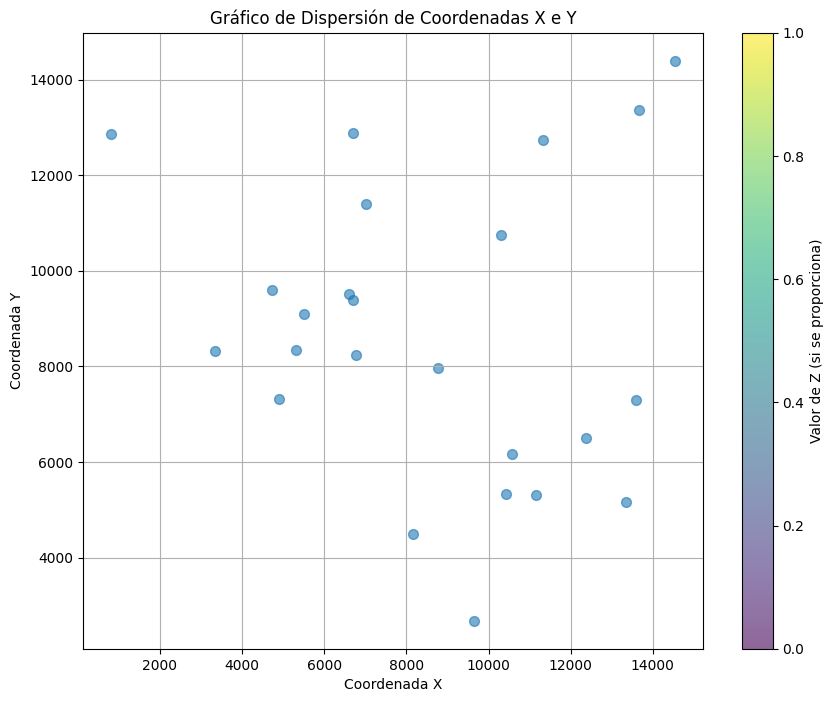

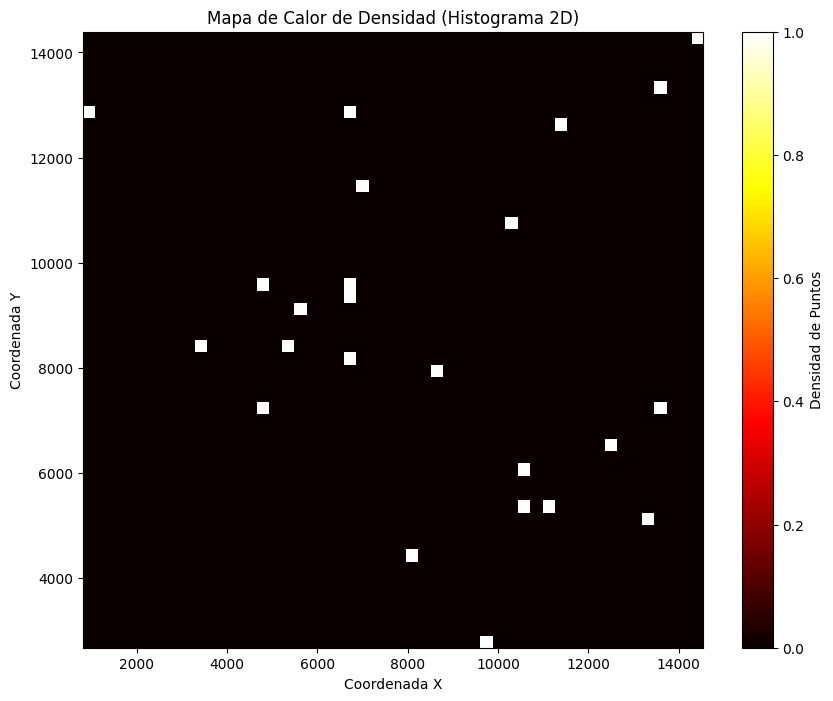

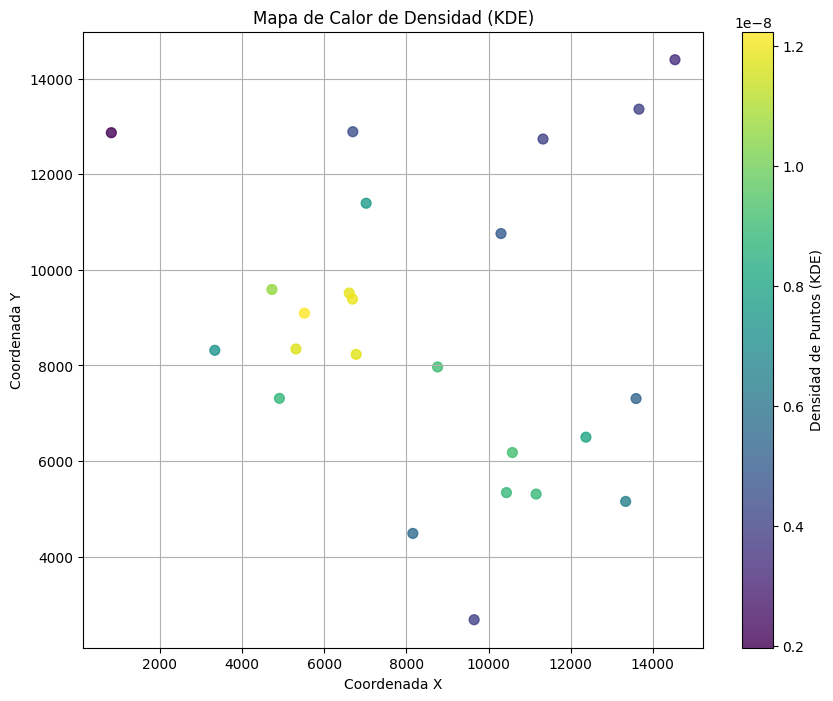

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Reemplaza estos datos con tus coordenadas 'x' y 'y' de la imagen ---
# Ejemplo de datos (reemplaza con los valores de la imagen)
# Puedes copiar y pegar las columnas 'x' e 'y' de la tabla de la imagen aquí
x = np.array([14539, 8760, 12371, 6690, 13663, 11327, 3338, 10304, 11160, 5313, 4729, 819, 6779, 13592, 9650, 8158, 4910, 6609, 6697, 7022, 10436, 10581, 5519, 13338])
y = np.array([14394, 7968, 6499, 9388, 13360, 12735, 8316, 10758, 5309, 8344, 9588, 12868, 8231, 7307, 2681, 4486, 7311, 9514, 12888, 11392, 5340, 6178, 9093, 5155])

# --- Creación del mapa de calor con scatter plot ---

# 1. Gráfico de dispersión básico
plt.figure(figsize=(10, 8))
plt.scatter(x, y, s=50, alpha=0.6, cmap='viridis') # 's' es el tamaño del marcador, 'alpha' es la transparencia

plt.title('Gráfico de Dispersión de Coordenadas X e Y')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.colorbar(label='Valor de Z (si se proporciona)') # Si no tienes un valor Z, esta barra no será muy útil
plt.show()

# 2. Mapa de calor usando un histograma 2D (más parecido a un mapa de calor de densidad)
# Esto te permite ver las regiones donde hay mayor concentración de puntos.
plt.figure(figsize=(10, 8))
hist, xedges, yedges = np.histogram2d(x, y, bins=50) # 'bins' controla la granularidad del mapa de calor
plt.imshow(hist.T, origin='lower', extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], cmap='hot', aspect='auto')
plt.colorbar(label='Densidad de Puntos')
plt.title('Mapa de Calor de Densidad (Histograma 2D)')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.show()

# 3. Mapa de calor usando Kernel Density Estimation (KDE) para una suavidad mayor
# Esto proporciona una estimación más suave de la densidad de puntos.
try:
    from scipy.stats import gaussian_kde
    # Combina x e y en un array de 2D
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Ordena los puntos por la densidad para que los puntos más densos se dibujen encima
    idx = z.argsort()
    x_kde, y_kde, z_kde = x[idx], y[idx], z[idx]

    plt.figure(figsize=(10, 8))
    plt.scatter(x_kde, y_kde, c=z_kde, s=50, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Densidad de Puntos (KDE)')
    plt.title('Mapa de Calor de Densidad (KDE)')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True)
    plt.show()

except ImportError:
    print("La librería SciPy no está instalada. No se puede generar el mapa de calor con KDE.")
    print("Puedes instalarla con: pip install scipy")